In [20]:
import requests
import lxml.html as lh
import pandas as pd
import numpy as np
import re #regex
import os
from datetime import date, datetime, timedelta
import math
from scipy.optimize import curve_fit


import matplotlib.pyplot as plt
import seaborn as sns
# Set style & figures inline
sns.set()
%matplotlib inline

## Web Scrapping Functions

In [21]:
# Extracts data from the webpage using lxml.html
def extract_table(url,xpath_all,contains_header):
    
    #Create a handle, page, to handle the contents of the website
    page = requests.get(url)
    #Store the contents of the website under doc
    doc = lh.fromstring(page.content)

    col_all=[]
    nrows=[] # number of rows for each table
    
    for xpath in xpath_all:
        print("Path used in collecting data: {}".format(xpath))
        #Parse data that are stored between <tr>..</tr> of HTML
        tr_elements = doc.xpath(xpath)
        
        #Check the number of columns of the first 12 rows
        print("Number of columns of the table:")
        print([len(T) for T in tr_elements[:18]])

        #Create empty list
        #tables that store a header (if there's one) and data
        #assuming all tables have the same header
        col=[]  

        ## Getting header
        i=0
        #For each row, store each first element (header)
        #and an empty list
        print("Table Header:")
        for t in tr_elements[0]:
            if contains_header==True:
                name=t.text_content()
            else:
                name=contains_header[i]
            i+=1
            print('%d:"%s"'%(i,name))
            col.append((name,[]))
            
        ## Getting data
        if contains_header==True:
            start_ind = 1
        else:
            start_ind = 0

        #nrows_current = 0
        for j in range(start_ind,len(tr_elements)):

            # break if reaching end of table
            #if len(tr_elements[j]) != len(tr_elements[0]):
            if j > 14:
                break
            i = 0    
            for ele in tr_elements[j].iterchildren():
                data = ele.text_content().strip()

                #check data
                p1 = re.search("^[A-Za-z]+", data)
                p2 = re.search('^[0-9,]+[\\n]*', data)

                if p1:
                    col[i][1].append(data)
                elif p2:
                    value = data[:p2.span()[1]].replace(",","")
                    if (re.search("\\n", value)):
                        value = value[:-1]
                    col[i][1].append(int(value))

                #Increment i for the next column
                i+=1
            
        col_all.append(col)
    return col_all

# Stores extracted data into dataframe(s)
def create_dataframe(table,num_table):

    df_all = pd.DataFrame()

    for t in range(0,num_table):
        Dict={title:column for (title,column) in table[t]}
        df=pd.DataFrame(Dict)
        df['Date'] = date.today()
        df_all=df_all.append(df,ignore_index=True)

    return df_all

## Extract data from the web

In [22]:
# Obtained data from the following website
url='https://www.covid-19canada.com'
#xpath1_1='//tr'
xpath1_1='//table[@id="canada-board"]//tr'
header = ["Province", "Total Confirmed", "Total Deaths", "Total Recovered", "Total Active"]
data = extract_table(url,[xpath1_1], contains_header=header)

print(data)

Path used in collecting data: //table[@id="canada-board"]//tr
Number of columns of the table:
[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
Table Header:
1:"Province"
2:"Total Confirmed"
3:"Total Deaths"
4:"Total Recovered"
5:"Total Active"
[[('Province', ['Prov.', 'Total', 'BC', 'ON', 'QC', 'AB', 'MB', 'NB', 'SK', 'PEI', 'NL', 'NS', 'YT', 'NT', 'NU']), ('Total Confirmed', ['Total Confirmed', 1423889, 148487, 548347, 376431, 232806, 57204, 2346, 49450, 208, 1437, 5873, 502, 128, 657]), ('Total Deaths', ['Total Deaths', 26504, 1763, 9294, 11236, 2316, 1165, 46, 575, 0, 7, 92, 6, 0, 4]), ('Total Recovered', ['Total Recovered', 1392777, 146062, 537698, 364539, 229885, 55117, 2291, 48613, 208, 1376, 5774, 420, 128, 653]), ('Total Active', ['Total Active', 4595, 653, 1355, 656, 605, 922, 9, 262, 0, 50, 7, 76, 0, 0])]]


In [23]:
df_1 = create_dataframe(data,len([xpath1_1]))

#remvoe the first row (header)
df_1.drop(labels = [0], axis = 0, inplace = True)
df_1.reset_index(drop = True, inplace = True)
print(df_1)

   Province Total Confirmed Total Deaths Total Recovered Total Active  \
0     Total         1423889        26504         1392777         4595   
1        BC          148487         1763          146062          653   
2        ON          548347         9294          537698         1355   
3        QC          376431        11236          364539          656   
4        AB          232806         2316          229885          605   
5        MB           57204         1165           55117          922   
6        NB            2346           46            2291            9   
7        SK           49450          575           48613          262   
8       PEI             208            0             208            0   
9        NL            1437            7            1376           50   
10       NS            5873           92            5774            7   
11       YT             502            6             420           76   
12       NT             128            0           

## Combine new daily extracted data to previous data

In [24]:
### Export the current df to existing file (previous data)
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data")
os.makedirs(save_path, exist_ok = True)

num_dataset = len(df_1.index)


for i in range(num_dataset):
    temp_df = df_1.loc[df_1[df_1.columns[0]] == df_1.loc[i][df_1.columns[0]]]

    #load current df and then perform merge before saving
    file_fullpath = os.path.join(save_path,df_1.loc[i][df_1.columns[0]] + ".csv")
    if os.path.exists(file_fullpath):
        orig_dataset = pd.read_csv(file_fullpath)    
        
        #reindex new df to match with existing data
        temp_df.reindex(columns=orig_dataset.columns)
        
        new_dataset = pd.merge(orig_dataset, temp_df, how = 'outer', 
                               on = list(orig_dataset.columns))
        new_dataset.drop_duplicates(subset=['Total Confirmed','Date'], 
                                    keep = 'first', inplace = True)
        #print(new_dataset)
        new_dataset.to_csv(file_fullpath, index = False)
    else:
        temp_df.to_csv(file_fullpath, index = False)

## Examine the data

In [25]:
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data")

# select the provinces to look at
target = ['Total', 'ON', 'QC', 'BC', 'AB']

df = []
# import updated data
for i in range(len(target)):
    file_fullpath = os.path.join(save_path, target[i] + ".csv")
    df_temp = pd.read_csv(file_fullpath)
    #df_temp.drop_duplicates(subset=['Total Confirmed','Date'], keep = 'first', inplace = True)
    df_temp.drop_duplicates(subset=['Province', 'Date'], keep = 'last', inplace = True)
    #print(df_temp.tail(2))
    #continue
    df_temp = df_temp.set_index('Date')
    df.append(df_temp)
    
    #print('\n\n****** ' + df_temp['Province'][0] + ' ******')
    #print(df_temp.tail(5))
    #df_temp.iloc[:, 1:5].plot(figsize=(20,10), style='o', ms=10, fontsize=20, rot = 45)
    #plt.xlabel('Date', fontsize=20);
    #plt.ylabel('Patients count', fontsize=20);
    #plt.title('Time Series for ' + target[i], fontsize=20)
    #plt.show()

## 1st Model Fitting: Gaussian

In [26]:
# function for fitting (normal distribution function)
def func_normal(x,a,x0,sigma):
    return (a/sigma)*np.exp(-(x-x0)**2/(2*sigma**2))

# specify the formats of dates in the dataset
def try_parsing_date(text):
    for fmt in ('%Y-%m-%d', '%d-%m-%Y'):
        try:
            return datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError('no valid date format found')
    
# dividing zero function
def division(r,d):
    return (r / d if d != 0 else r)

In [59]:
# computes the weekly average
def getWeeklyAverage(xdata, x_data_in_day, y_data_change_per_day, year_start):
    #year_start = 2020
    
    df = pd.DataFrame(data = {'Date': xdata, 
                              'Date_Num': x_data_in_day, 
                              'Daily_Increase': y_data_change_per_day})
    df['Date_formatted'] = pd.to_datetime(df['Date'], format="%d-%m-%Y",  errors='coerce')
    mask = df.Date_formatted.isnull()
    df.loc[mask, 'Date_formatted'] = pd.to_datetime(df[mask]['Date'], 
                                                    format="%Y-%m-%d", errors='coerce')
    #df['Week'] = df['Date_formatted'].dt.week
    df['Week'] = df['Date_formatted'].dt.isocalendar().week #get week number
    
    df.loc[(df['Date_formatted'].dt.year > year_start) & 
                   (df['Week'] < date(year_start,12,31).isocalendar()[1]), 'Week'] = \
    df['Date_formatted'].dt.isocalendar().week + date(year_start, 12, 31).isocalendar()[1]
    
    df['Week_midpoint'] = df.groupby('Week')[['Date_Num']].transform('median')
    
    #print(df.tail(10))
    #print(df.groupby('Week')['Date_formatted'].transform('min'))
    
    weekly_avg = df.groupby('Week')[['Week_midpoint','Daily_Increase']].mean()
    #print(weekly_avg)
    return weekly_avg


# computes the 7-day average
def getSevenDayAverage(xdata, x_data_in_day, y_data_change_per_day, year_start):
    
    df = pd.DataFrame(data = {'Date': xdata, 
                              'Date_Num': x_data_in_day, 
                              'Daily_Increase': y_data_change_per_day})
    df['Date_formatted'] = pd.to_datetime(df['Date'], format="%d-%m-%Y",  errors='coerce')
    mask = df.Date_formatted.isnull()
    df.loc[mask, 'Date_formatted'] = pd.to_datetime(df[mask]['Date'], 
                                                    format="%Y-%m-%d", errors='coerce')
    #df['Week'] = df['Date_formatted'].dt.week
    df['Week'] = df['Date_formatted'].dt.isocalendar().week #get week number
    
    df.loc[(df['Date_formatted'].dt.year > year_start) & 
                   (df['Week'] < date(year_start,12,31).isocalendar()[1]), 'Week'] = \
    df['Date_formatted'].dt.isocalendar().week + date(year_start, 12, 31).isocalendar()[1]
    df['Week_midpoint'] = df.groupby('Week')[['Date_Num']].transform('median')

    
    # compute the simple moving average
    df['SMA_7'] = df['Daily_Increase'].rolling(window=7).mean()

    sevenDayAvg = df[['Date_Num','SMA_7']]    
    return sevenDayAvg



****** Total ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-07-15    Total        1422116.0       26470.0        1390832.0   
2021-07-16    Total        1422495.0       26485.0        1391230.0   
2021-07-17    Total        1422822.0       26492.0        1391609.0   
2021-07-18    Total        1423177.0       26499.0        1392062.0   
2021-07-19    Total        1423889.0       26504.0        1392777.0   

            Total Active  
Date                      
2021-07-15        4798.0  
2021-07-16        4764.0  
2021-07-17        4705.0  
2021-07-18        4600.0  
2021-07-19        4595.0  


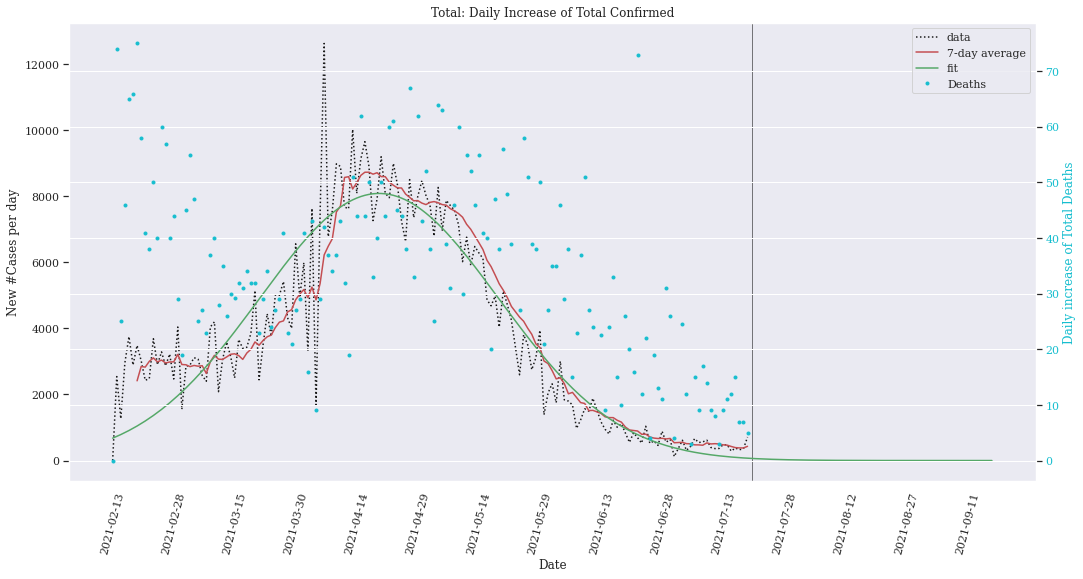



****** ON ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-07-15       ON         547705.0        9275.0         536987.0   
2021-07-16       ON         547864.0        9285.0         537176.0   
2021-07-17       ON         548040.0        9288.0         537379.0   
2021-07-18       ON         548217.0        9294.0         537545.0   
2021-07-19       ON         548347.0        9294.0         537698.0   

            Total Active  
Date                      
2021-07-15        1443.0  
2021-07-16        1403.0  
2021-07-17        1373.0  
2021-07-18        1378.0  
2021-07-19        1355.0  


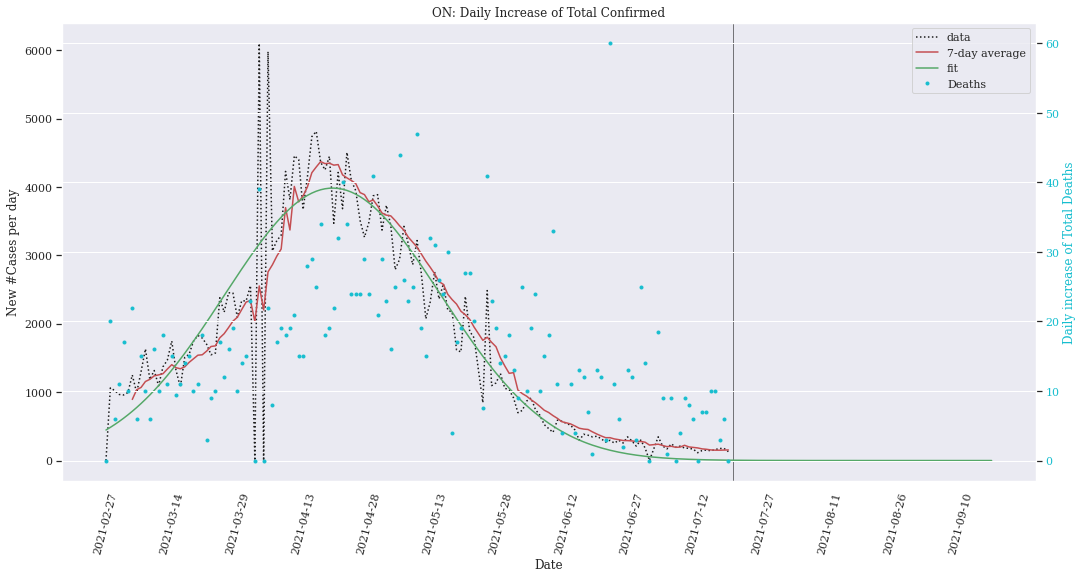



****** QC ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-07-15       QC         376109.0       11232.0         364222.0   
2021-07-16       QC         376192.0       11235.0         364328.0   
2021-07-17       QC         376192.0       11235.0         364328.0   
2021-07-18       QC         376192.0       11235.0         364328.0   
2021-07-19       QC         376431.0       11236.0         364539.0   

            Total Active  
Date                      
2021-07-15         655.0  
2021-07-16         629.0  
2021-07-17         629.0  
2021-07-18         629.0  
2021-07-19         656.0  


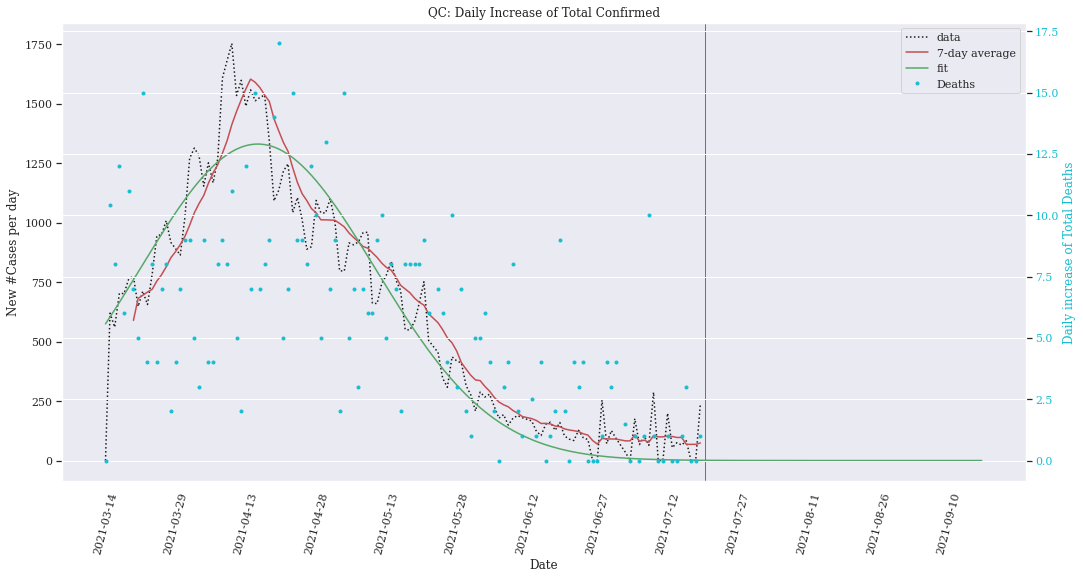



****** BC ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-07-15       BC         148228.0        1760.0         145817.0   
2021-07-16       BC         148286.0        1761.0         145859.0   
2021-07-17       BC         148331.0        1761.0         145908.0   
2021-07-18       BC         148331.0        1761.0         145908.0   
2021-07-19       BC         148487.0        1763.0         146062.0   

            Total Active  
Date                      
2021-07-15         639.0  
2021-07-16         654.0  
2021-07-17         650.0  
2021-07-18         650.0  
2021-07-19         653.0  


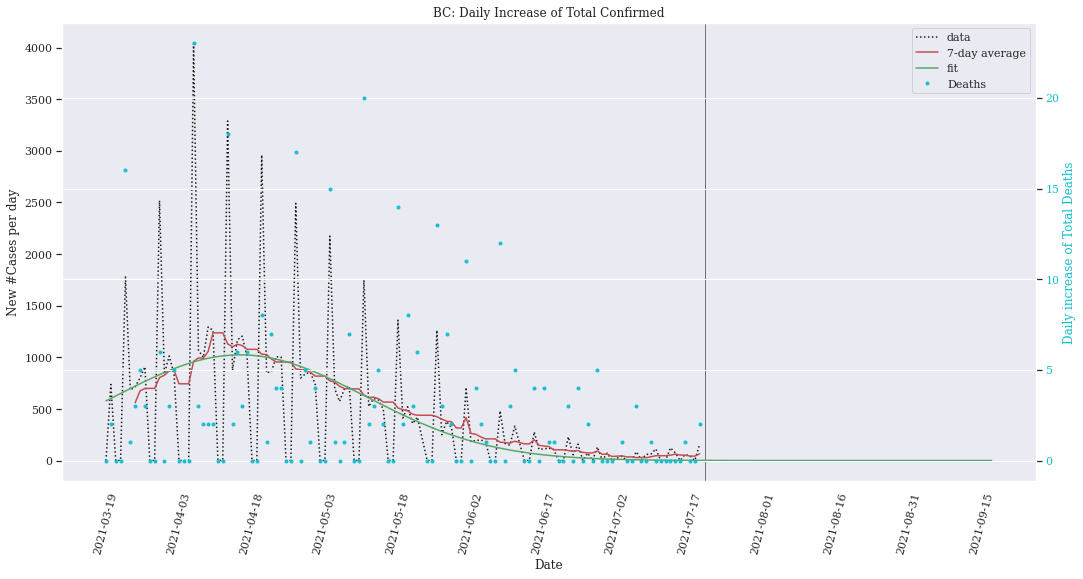



****** AB ******
           Province  Total Confirmed  Total Deaths  Total Recovered  \
Date                                                                  
2021-07-15       AB         232582.0        2311.0         229702.0   
2021-07-16       AB         232635.0        2312.0         229745.0   
2021-07-17       AB         232676.0        2314.0         229783.0   
2021-07-18       AB         232676.0        2314.0         229783.0   
2021-07-19       AB         232806.0        2316.0         229885.0   

            Total Active  
Date                      
2021-07-15         569.0  
2021-07-16         578.0  
2021-07-17         579.0  
2021-07-18         579.0  
2021-07-19         605.0  


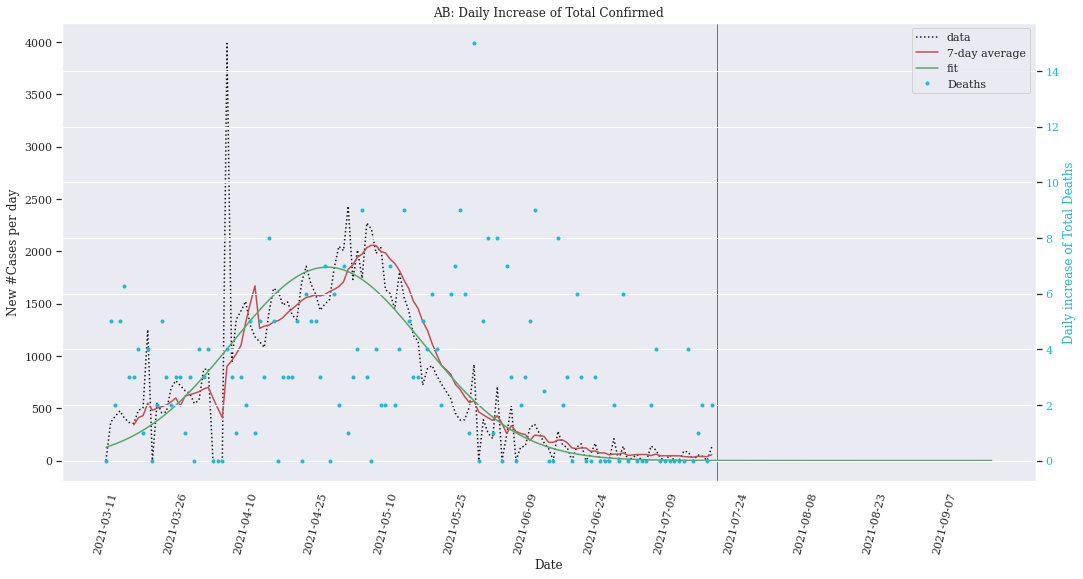

In [60]:
for cur_df in df:
    
    #define main axis parameter
    data_examined = cur_df.columns.get_loc('Total Confirmed')
    #define secondary axis parameter
    second_param = 'Total Deaths'
    
    ydata = cur_df.iloc[:, data_examined].transpose()
    xdata = cur_df.index
    
    # 2021-04-16 added #########################
    # ignore the first 340 data points to look at the 3rd wave
    start_point = 340
    xdata = xdata[start_point:]
    ydata = ydata[start_point:]
    ############################################
    # 2021-06-14 added
    from datetime import datetime
    today = datetime.today()
    days_diff = today - try_parsing_date(xdata[0])
    #print(days_diff.days)
    ############################################
    
    xdata = xdata[~ydata.apply(np.isnan)]
    ydata = ydata[~ydata.apply(np.isnan)]#ydata.replace(np.nan, '', regex=False)
    
    x_data_2 = [try_parsing_date(x) for x in xdata]
    year_start = x_data_2[0].year
    
    # convert time to days since first record
    x_data_in_sec = [int(x.timestamp()) - int(x_data_2[0].timestamp()) for x in x_data_2]
    x_data_in_day  = np.array([x / 3600 / 24 for x in x_data_in_sec])
    
    # compute the increase in confirmed cases from total
    x_data_in_day_diff = np.ediff1d(x_data_in_day, to_begin=0)
    y_data_change = np.ediff1d(ydata, to_begin=0)
    y_data_change_per_day = np.array([division(y,x) for y,x in 
                                      zip(y_data_change,x_data_in_day_diff)])
    
    # compute the weekly average
    weekly_avg = getWeeklyAverage(xdata, x_data_in_day, y_data_change_per_day, year_start)
    # compute the seven day average
    sevenDayAvg = getSevenDayAverage(xdata, x_data_in_day, y_data_change_per_day, year_start)
    
    # ignore datapoints where count is zero
    #nonzero_indices = np.where(y_data_change_per_day != 0.0)[0]
    #x_data_in_day = x_data_in_day[nonzero_indices]
    #y_data_change_per_day = y_data_change_per_day[nonzero_indices]

    
    print('\n\n****** ' + cur_df['Province'][0] + ' ******')
    print(cur_df.tail(5))
    
    
    # compute the curvefit
    n = len(x_data_in_day)
    mean = float(sum(y_data_change_per_day))/n
    sigma = np.sqrt(sum((y_data_change_per_day-mean)**2))/np.sqrt(n-1)
    init_vals = [10000, mean, sigma]
       
    # fit your data and getting fit parameters
    popt, pcov = curve_fit(func_normal, x_data_in_day, y_data_change_per_day, 
                           p0=init_vals, maxfev = 100000)
    
    
    # Create the figures
    x_end = math.ceil(x_data_in_day[len(x_data_in_day)-1])
    x_extend = np.array(range(x_end, x_end+61))
    
    xdisplay = [ (try_parsing_date(cur_df.index[start_point]) + 
                  timedelta(days=t)).strftime("%Y-%m-%d") for t in range(0,max(x_extend))]
        
    fig, ax = plt.subplots(figsize=(15,8))
    #plt.clf()
    
    #font settings
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'figure.autolayout': True, 
                         'font.size': 5})    
    
    # vertical and horizontal lines
    plt.axvline(x=days_diff.days, color = 'black', linewidth=0.5)
    plt.axhline(y=0, color = 'black', linewidth=0.5)
    
    # data lines
    lns1 = ax.plot(x_data_in_day, y_data_change_per_day, 'k:', label='data')
    
    # weekly average
    #lns2 = ax.plot(weekly_avg['Week_midpoint'], weekly_avg['Daily_Increase'], 
    #         'r-', label = 'weekly average')
    # seven day average
    lns2 = ax.plot(sevenDayAvg['Date_Num'], sevenDayAvg['SMA_7'], 
             'r-', label = '7-day average')
    
    lns3 = ax.plot(np.concatenate((x_data_in_day, x_extend)), 
             func_normal(np.concatenate((x_data_in_day, x_extend)), *popt), 
             'g-', label='fit')
    
    plt.xticks(np.arange(x_data_in_day[0], max(x_data_in_day) + max(x_extend), step = 15), 
           labels = xdisplay[::15], rotation=75)
    
    ## secondary axis
    # fit your data and getting fit parameters
    ydata_2ndry = cur_df[second_param].fillna(value = 0, inplace = False)[start_point:]
    ydata_2ndry_change = np.ediff1d(ydata_2ndry, to_begin=0)
    ydata_2ndry_change_per_day = np.array([division(float(y),float(x)) for y,x in 
                                      zip(ydata_2ndry_change,x_data_in_day_diff)])
    # any daily increase less than zero is set as 0
    ydata_2ndry_change_per_day[ydata_2ndry_change_per_day<0] = 0
    
    ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:cyan'
    ax2.set_ylabel('Daily increase of ' + second_param, color=color)
    lns4 = ax2.plot(x_data_in_day, ydata_2ndry_change_per_day, 'c.', 
                    color=color, label= 'Deaths')
    #ax2.plot(np.concatenate((x_data_in_day, x_extend)), 
    #         func_normal(np.concatenate((x_data_in_day, x_extend)), *popt2), 
    #         'm-', label='fit')
    ax2.tick_params(axis='y', labelcolor=color)
    
    # Legend
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)
    
    ax.grid()
    ax.set_xlabel('Date')
    ax.set_ylabel('New #Cases per day')
    ax.set_title(cur_df['Province'][0] + ': Daily Increase of ' + cur_df.columns[data_examined])
    plt.show()
    
    from sklearn.metrics import mean_squared_error
    # Calculation of Mean Squared Error (MSE) 
    y_pred = np.array(func_normal(x_data_in_day, *popt))
    #print("MSE: {}".format(mean_squared_error(y_data_change_per_day, y_pred)))


## 2nd model: Linear Regression on Cum. Cases in Logarithmic scale

In [29]:
#for cur_df in df[0:1][:]:
cur_df = df[0][:]            #only look at all the cases in Canada

#get today's date and time
today = (datetime.today() - try_parsing_date(cur_df.index[0])).days

#format x and y data for plot
xdata = cur_df.index
x_data_2 = [try_parsing_date(x) for x in xdata]
ydata = cur_df.iloc[:, 1]#.transpose()

#remove NaN elements
temp_ind = np.argwhere(~np.isnan(ydata.to_list()))
ydata = [ydata.to_list()[int(x)] for x in temp_ind]
x_data_2 = [x_data_2[int(x)] for x in temp_ind]

x_data_in_sec = [int(x.timestamp()) - int(x_data_2[0].timestamp()) for x in x_data_2]
x_data_in_day  = [x / 3600 / 24 for x in x_data_in_sec]

# ignore the first 450 data points
start_point = 450
x_data_in_day = x_data_in_day[start_point:]
ydata = ydata[start_point:]

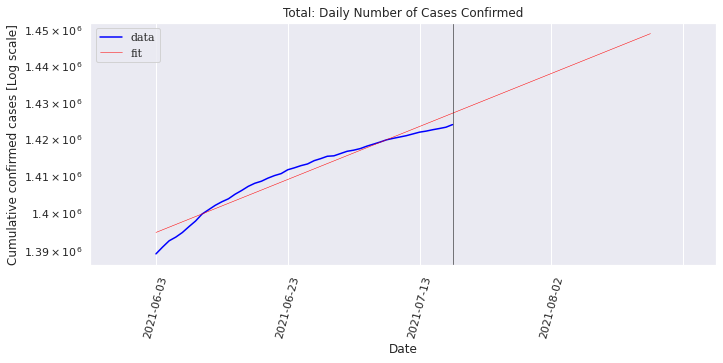

In [30]:
# curve fit, in log scale for y
#1.
#m = False
#2.
m, c = np.polyfit(x_data_in_day, np.log(ydata), 1) # fit log(y) = m*log(x) + c

#Plot: log scale in y-axis
fig,ax = plt.subplots(1, 1, figsize=(10,5))
ax.set_yscale('log', basey=10)

x_end = math.ceil(x_data_in_day[len(x_data_in_day)-1])
x_extend = np.array(range(x_end, x_end+31))

# calculate the fitted values of y
if (m != False):
    y_fit = np.exp([m*x + c for x in np.concatenate((x_data_in_day, x_extend))])

xdisplay = [ (try_parsing_date(cur_df.index[0])
              + timedelta(days=t)).strftime("%Y-%m-%d") 
            for t in range(int(x_data_in_day[0]), max(x_extend))]

plt.rcParams.update({'font.size': 42})
plt.rcParams.update({'figure.autolayout': True, 
                     'font.size': 5, 
                     'font.family': 'serif', 
                     'font.sans-serif': ['Helvetica']})    


plt.plot(x_data_in_day, ydata, color = 'blue', label='data')
if (m != False):
    plt.plot(np.concatenate((x_data_in_day, x_extend)), 
            y_fit, color = 'red', linewidth=0.5, label='fit')
plt.axvline(x=today, color = 'black', linewidth=0.5)

plt.xticks(np.arange(min(x_data_in_day), max(x_data_in_day) + max(x_extend), step = 20), 
           labels = xdisplay[::20], rotation=75)
plt.yticks(np.arange(10^6, 2*10^6, step = 5*10^5), 
           labels = np.arange(10^6, 2*10^6, step = 5*10^5))

plt.xlim(min(x_data_in_day)-10, max(x_extend)+10)
#if (m != False):
#    plt.ylim(min(ydata)/1.5, max(y_fit)*1.5)

plt.xlabel('Date')
plt.ylabel('Cumulative confirmed cases [Log scale]')
plt.title(cur_df['Province'][0] + ': Daily Number of Cases Confirmed')
plt.legend()
plt.show()

# Covid19 Vaccine Distribution

In [31]:
import os
import pandas as pd
import selenium
from selenium import webdriver
import time
from PIL import Image
import io
import requests
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
#from selenium.common.exceptions import ElementClickInterceptedException
#import chromedriver_binary

In [32]:
# Extracts data from the webpage using selenium
def extract_table2(url, xpath_header, xpath_content):
    # Install Driver
    driver = webdriver.Chrome(ChromeDriverManager().install())
    driver.get(url)

    try:
        element = WebDriverWait(driver, 60).until(
            EC.presence_of_element_located((By.XPATH, xpath_content))
        )
        #extracting data
        header = driver.find_elements_by_xpath(xpath_header)  #NOT driver.find_element_by_xpath()
        table = driver.find_elements_by_xpath(xpath_content)  #NOT driver.find_element_by_xpath()
    except:
        print("Issue with extracting info from the Chrome Browser. Please check")
        os. _exit()

    trow = []
    for num_row in range(len(table)):
        trow.append(table[num_row].text)
    theader = []
    for each_header in range(len(header)):
        # Updated in June 2021 (remove "\n"):
        theader.append(header[each_header].text.replace("\n", " "))
        

    # Prior June 2021
    #data = [[x.split('\n')[0]] + x.split('\n')[1].split(' ', 6) for x in trow]
    #print(data)
    
    # June 2021:
    data = [[re.split("\s\d",x)[0]] + re.split("(\d.+)", x)[1].split(' ',6) for x in trow]    
    
    # print info
    #print(trow)
    #print(theader)
    #print(data)
    
    # Create dataframe
    df = pd.DataFrame(data, columns = theader)
    #df
    # close chrome
    driver.quit()

    return df

In [33]:
### Export the current df to existing file (previous data)
def save_dataset(save_path, df_1):
    os.makedirs(save_path, exist_ok = True)
    num_dataset = len(df_1.index)

    for i in range(num_dataset):
        temp_df = df_1.loc[df_1[df_1.columns[0]] == df_1.loc[i][df_1.columns[0]]]

        ## load current df and then perform merge before saving
        file_fullpath = os.path.join(save_path,df_1.loc[i][df_1.columns[0]] + ".csv")
        if os.path.exists(file_fullpath):
            orig_dataset = pd.read_csv(file_fullpath, dtype = object)

            
            #PRIOR June 2021
            
            ## run if need to update the header
            #tmpHeader = list(temp_df.columns)
            #target = tmpHeader.pop(2)
            #new_tmp = tmpHeader + [target]
            #orig_dataset.columns = new_tmp #temp_df.columns
            
            ## reindex new df to match with existing data
            #temp_df.reindex(columns=orig_dataset.columns)
            
            ## '% Age population' column: 'Age' may change -->
            #fix_columns_headers = (orig_dataset.columns[:-2]).append(pd.Index([orig_dataset.columns[-1]]))
            

            # June 2021:
            if set(temp_df.columns).issubset(set(orig_dataset.columns)):
                print("NO new columns introduced...continue")
                fix_columns_headers = temp_df.columns
            else:
                print("New columns introduced in new data. Please check first")
                print(orig_dataset.columns)
                #print(dict(orig_dataset.dtypes))
                print(temp_df.columns)
                #print(dict(temp_df.dtypes))
                break
            
            #Merge datasets
            new_dataset = pd.merge(orig_dataset, temp_df, how = 'outer', 
                                   on = list(fix_columns_headers))

            
            new_dataset.drop_duplicates(subset=['Province/Territory', 'Updated'], #list(new_dataset.columns), 
                                        keep = 'last', inplace = True)
            #print(new_dataset)
            new_dataset.to_csv(file_fullpath, index = False)
        else:
            temp_df.to_csv(file_fullpath, index = False)
    


In [34]:
#Specify Search URL 
url='https://www.ctvnews.ca/health/coronavirus/coronavirus-vaccine-tracker-how-many-people-in-canada-have-received-shots-1.5247509'
#url='https://www.python.org'

#old xpath
# xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/thead/th'
# xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/tbody/tr'
#paths updated on March 6th
#xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[4]/table/thead/th'
#xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[4]/table/tbody/tr'
#paths updated on March 26th: new column
#xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/thead/th'
#xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[5]/table/tbody/tr'
#paths updated on June 17th, 2021
#xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[6]/table/thead/th'
#xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[2]/div/div[6]/table/tbody/tr'
#paths updated on June 23, 2021
xpath2_header = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[1]/div/div[6]/table/thead/th'
xpath2_content = '//*[@id="responsive_main"]/section/div/div/div[2]/div[1]/div[1]/div/div[6]/table/tbody/tr'

#Extract data and store into a dataframe
df_vac = extract_table2(url, xpath2_header, xpath2_content)


[WDM] - ====== WebDriver manager ======


[WDM] - Current google-chrome version is 91.0.4472
[WDM] - Get LATEST driver version for 91.0.4472
[WDM] - Get LATEST driver version for 91.0.4472
[WDM] - Trying to download new driver from https://chromedriver.storage.googleapis.com/91.0.4472.101/chromedriver_win32.zip
[WDM] - Driver has been saved in cache [C:\Users\Powell\.wdm\drivers\chromedriver\win32\91.0.4472.101]


In [35]:
df_vac

,Province/Territory,Total Percentage vaccinated,Total % Fully vaccinated,Eligible (12+) Percentage vaccinated,Eligible (12+) % Fully vaccinated,Received from manufacturer,Received doses administered,Updated
0,Yukon,79.0%,68.8%,96.0%,83.7%,"65,690",94.7%,Jul. 19
1,Northwest Territories,72.6%,66.3%,86.5%,79.0%,"82,230",76.3%,Jul. 19
2,Prince Edward Island,75.8%,33.7%,86.1%,38.2%,"221,015",79.1%,Jul. 15
3,Nova Scotia,74.0%,49.5%,83.2%,55.7%,"1,392,270",86.9%,Jul. 19
4,Quebec,71.9%,46.0%,82.4%,52.7%,"11,571,657",87.4%,Jul. 19
5,Newfoundland and Labrador,76.1%,37.5%,82.2%,40.5%,"753,080",78.8%,Jul. 19
6,New Brunswick,71.4%,51.6%,80.4%,58.1%,"1,069,825",89.8%,Jul. 19
7,British Columbia,71.8%,47.7%,80.0%,53.2%,"6,744,280",91.5%,Jul. 19
8,Manitoba,67.8%,53.5%,79.5%,62.7%,"2,071,070",80.7%,Jul. 19
9,Canada,69.7%,50.3%,79.3%,57.2%,"52,957,928",86.3%,Jul. 19


In [36]:
#Save data on vaccine
current_dir = os.getcwd()
save_path = os.path.join(current_dir,"data","vaccine")
save_dataset(save_path, df_vac)

import datetime
now = datetime.datetime.now()

print("data saved at: "+str(now))

NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
NO new columns introduced...continue
data saved at: 2021-07-19 23:12:59.929327


In [37]:
#END